<a href="https://colab.research.google.com/github/chuan137/egohands/blob/master/grocery/grocery_categories_v07_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Note

__Description__ 

__Update__ 
* use orignal png images
* use **image data generator** for augmentation, and splitting validation and train data

### Training details

**Train data**
* 3 categories: BEANS, CAKE, CANDY 
* image size 224

**Architecture**
* one fully connected layer
* prediction layer with L2 regularizer

**Hyper parameters**
* softmax layer with regularizer, weight = 0.0001
* optimizer Adam, learning rate 0.001


## Prepare

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cp /content/drive/My\ Drive/freiburg_groceries_dataset.zip .
!unzip -q freiburg_groceries_dataset.zip

## Load Data

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [28]:
# CLASSES = ['BEANS', 'CAKE', 'CANDY', 'MILK', 'TEA', 'COFFEE']
CLASSES = ['CANDY', 'COFFEE']
SEED = 7876


# split images into train/validation/test directories
import os
import random
from shutil import rmtree, copyfile

random.seed(SEED)

def split_images(imgdir, 
                 splits=(0.7,0.2,0.1), 
                 traindir='./images_train', 
                 valdir='./images_validation', 
                 testdir='./images_test' ):
    # remove and recreate train/val/test dir
    if os.path.exists(traindir):
        rmtree(traindir)
    if os.path.exists(valdir):
        rmtree(valdir)
    if os.path.exists(testdir):
        rmtree(testdir)
    os.mkdir(traindir)
    os.mkdir(valdir)
    os.mkdir(testdir)

    for cls in CLASSES:
        if os.path.exists(os.path.join(traindir, cls)):
            rmtree(os.path.join(traindir, cls))
        if os.path.exists(os.path.join(valdir, cls)):
            rmtree(os.path.join(valdir, cls))
        if os.path.exists(os.path.join(testdir, cls)):
            rmtree(os.path.join(testdir, cls))
        os.mkdir(os.path.join(traindir, cls))
        os.mkdir(os.path.join(valdir, cls))
        os.mkdir(os.path.join(testdir, cls))
     
     # shuffle original images and copy them to target directories
    for cls in CLASSES:
        images = []
        for filename in os.listdir(os.path.join(imgdir, cls)):
            p = os.path.join(cls, filename)
            images.append(p)
        random.shuffle(images)
        n = len(images)
        n1 = round(splits[0]*n)
        n2 = n1 + round(splits[1]*n)
        print('split images of CLASS %s in (train, validation, test): (%d, %d, %d)' % (cls, n1, n2-n1, n - n2))
        for p in images[:n1]:
            copyfile(os.path.join(imgdir, p), os.path.join(traindir, p))
        for p in images[n1:n2]:
            copyfile(os.path.join(imgdir, p), os.path.join(valdir, p))
        for p in images[n2:]:
            copyfile(os.path.join(imgdir, p), os.path.join(testdir, p))

split_images('./images')

split images of CLASS CANDY in (train, validation, test): (260, 74, 38)
split images of CLASS COFFEE in (train, validation, test): (209, 60, 29)


In [0]:
# Parameters
file_descriptor = 'v07-c'
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Training hyper parameter
# algorithm: 'rms' or 'adam'
train_algo = 'rms'
dropout_rate = 0.2
learning_rate = 0.0001
w_l2 = 0.00001

#
n_classes = len(CLASSES)

In [45]:
# output files
base_dir = 'drive/My Drive/Colab Notebooks/grocery'
def save_filenames(base_network_name, test_descriptor, param, precision):
    descriptor = base_dir + '/' + base_network_name + '_' + test_descriptor + '_'
    name_csv = descriptor + str(round(param, precision)) + '.csv'
    name_weights = descriptor + str(round(param, precision)) + '.h5'
    return name_csv, name_weights

descriptor = file_descriptor + '-' + str(IMAGE_SIZE) + '-' + train_algo
file_csv, file_weights = save_filenames('MobileNetV2', descriptor, learning_rate, 6)
print(file_csv)
print(file_weights)

drive/My Drive/Colab Notebooks/grocery/MobileNetV2_v07-c-224-rms_0.0001.csv
drive/My Drive/Colab Notebooks/grocery/MobileNetV2_v07-c-224-rms_0.0001.h5


In [31]:
# data generator for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2, 
    rotation_range=10, 
    horizontal_flip=True)

datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    './images_train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen_val_test.flow_from_directory(
    './images_validation',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    class_mode='categorical',
    shuffle=True
)


Found 469 images belonging to 2 classes.
Found 134 images belonging to 2 classes.


In [32]:
# Pre-trained model with MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained model weights
base_model.trainable = False

# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
fc_layer_1 = tf.keras.layers.Dense(1280, activation='relu')
dropout_layer = tf.keras.layers.Dropout(dropout_rate)

# Prediction
prediction_layer = tf.keras.layers.Dense(
        n_classes,
        activation='softmax',
        # kernel_regularizer=tf.keras.regularizers.l2(w_l2)
)

# Model
model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    dropout_layer,
    fc_layer_1,
    prediction_layer
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1280)              1639680   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 2562      
Total params: 3,900,226
Trainable params: 1,642,242
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
# Compile the model
from tensorflow.keras.optimizers import RMSprop, Adam

if train_algo == 'rms':
    model.compile(
        optimizer=RMSprop(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
else:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

In [34]:
import os
labels_count = dict()
for img_class in CLASSES:
    labels_count[img_class] = len(os.listdir('images/' + img_class))
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in enumerate(labels_count.values())}
class_weights

{0: 1.8010752688172043, 1: 2.248322147651007}

In [0]:
# figsize=224, dropout rate 0.5

In [39]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau

n_epochs = 100
csv_logger = CSVLogger(filename=file_csv, append=True, separator=',')
early_stopping = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, min_lr=0.000001, patience=5, verbose=1)

hist = model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.n//BATCH_SIZE,
            epochs=n_epochs,
            validation_data=val_generator,
            validation_steps=val_generator.n//BATCH_SIZE,
            class_weight=class_weights,
            callbacks=[
                csv_logger,
                early_stopping,
                reduce_lr,
            ],
            # shuffle=True,
)

model.save_weights(file_weights)

Epoch 1/100
14/14 [==============================] - 10s 727ms/step - loss: 0.1690 - accuracy: 0.9657 - val_loss: 0.6039 - val_accuracy: 0.8672
Epoch 2/100
14/14 [==============================] - 10s 710ms/step - loss: 0.2679 - accuracy: 0.9542 - val_loss: 0.9739 - val_accuracy: 0.7734
Epoch 3/100
14/14 [==============================] - 10s 683ms/step - loss: 0.2544 - accuracy: 0.9634 - val_loss: 0.5256 - val_accuracy: 0.8828
Epoch 4/100
14/14 [==============================] - 10s 680ms/step - loss: 0.0952 - accuracy: 0.9794 - val_loss: 0.4738 - val_accuracy: 0.8984
Epoch 5/100
14/14 [==============================] - 9s 674ms/step - loss: 0.1765 - accuracy: 0.9680 - val_loss: 0.2563 - val_accuracy: 0.8984
Epoch 6/100
14/14 [==============================] - 9s 673ms/step - loss: 0.1522 - accuracy: 0.9771 - val_loss: 0.4545 - val_accuracy: 0.8906
Epoch 7/100
14/14 [==============================] - 10s 687ms/step - loss: 0.1727 - accuracy: 0.9710 - val_loss: 0.3274 - val_accuracy: 0

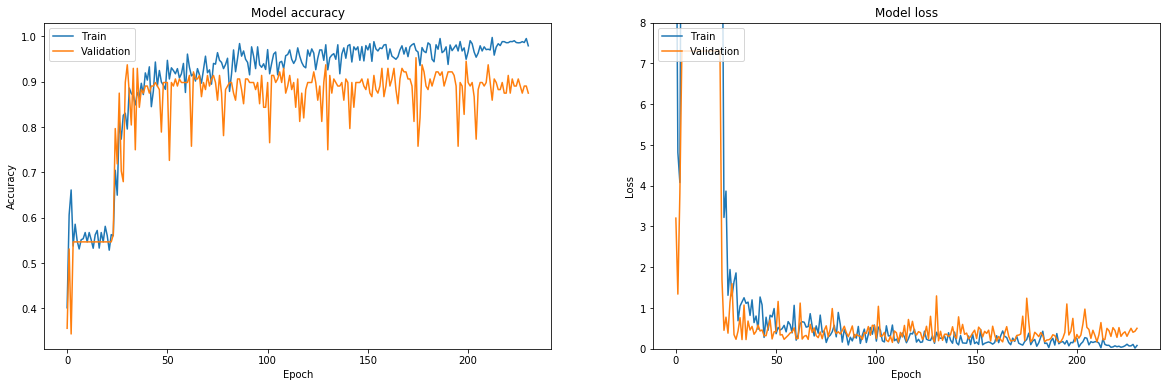

In [40]:
import csv

accuracy = []
loss = []
val_accuracy = []
val_loss = []

with open(file_csv) as f:
    csv_reader = csv.reader(f, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            # print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            accuracy.append(float(row[1]))
            loss.append(float(row[2]))
            val_accuracy.append(float(row[3]))
            val_loss.append(float(row[4]))
            line_count += 1

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

# Plot training & validation accuracy values
ax1.plot(accuracy)
ax1.plot(val_accuracy)
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
# ax1.ylim(0.5, 1.1)

# Plot training & validation loss values
ax2.plot(loss)
ax2.plot(val_loss)
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.set_ylim(0,8)
plt.show()   

In [41]:
# predcition

import numpy as np


test_generator = datagen_val_test.flow_from_directory(
    directory=r"./images_test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)


STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)


Found 67 images belonging to 2 classes.
67/67 [==============================] - 6s 87ms/step


In [42]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

image_nr = 0
for cls in sorted(os.listdir('./images_test')):
     for _ in os.listdir(os.path.join('./images_test', cls)):
         p = predictions[image_nr]
         print('x' if p == cls else '-', cls, p)
         image_nr += 1

x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
- CANDY COFFEE
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
- CANDY COFFEE
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
x CANDY CANDY
- CANDY COFFEE
x CANDY CANDY
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
- COFFEE CANDY
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
- COFFEE CANDY
x COFFEE COFFEE
- COFFEE CANDY
- COFFEE CANDY
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
x COFFEE COFFEE
